In [29]:
import numpy as np
from matplotlib import pyplot as plt
import torch

In [27]:
t_rise = 5e-3 
t_decay = 1e-2 # twice the rise time
t_j = 0 # time point for the spike

In [23]:
def epsilon(t, t_rise, t_decay, t_j):
    """
    Creates the double exponential kernel based on given spike time
    Inputs:
        t - array of time points
    """
    z_j = np.zeros_like(t)
    z_j[t >= t_j] = (1/(t_rise-t_decay))*(np.exp(-t[t>=t_j]/t_rise) - np.exp(-t[t>=t_j]/t_decay))
    return z_j

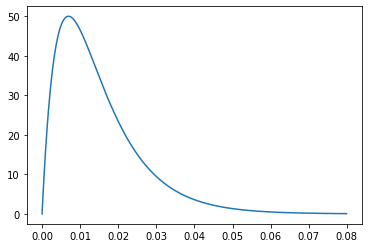

In [28]:
t = np.arange(0, 0.08, 0.0001) #10ms time bins
z_j = epsilon(t, t_rise, t_decay, t_j)

plt.plot(t, z_j)

How to "slap" this function on top of the existing trace at each spike time?

In [30]:
#@title Old Solution
def presynaptic_trace(input_trains, args):
  """
  Evaluates the presynaptic trace (double exponential kernel)
  given the whole input trains
  Inputs:
    input_trains
    args:['timestep_size', 't_rise', 't_decay', 'nb_steps']
  Returns:
    Presynaptic Trace 
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  
  nb_trains = len(input_trains)

  trace_1 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)
  trace_2 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)

  for t in range(nb_timesteps - 1):
    
  #  trace_1[:, t+1] = trace_1[:, t] + (-trace_1[:, t]/t_rise + input_trains[:, t])*dt
  #  trace_2[:, t+1] = trace_2[:, t] + (-trace_2[:, t] + trace_1[:, t])*dt/t_decay

    # New implementation (cognizant of the dirac delta):
    trace_1[:, t+1] = trace_1[:, t] + (-trace_1[:, t]/t_rise)*dt + input_trains[:, t]
    trace_2[:, t+1] = trace_2[:, t] + (-trace_2[:, t] + trace_1[:, t])*dt/t_decay
  
  return trace_2

In [ ]:
def new_presynaptic_trace(input_trains, args):
  """
  Evaluates the presynaptic trace (double exponential kernel)
  given the whole input trains
  Inputs:
    input_trains
    args:['timestep_size', 't_rise', 't_decay', 'nb_steps']
  Returns:
    Presynaptic Trace 
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  nb_trains = len(input_trains)

  time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

  # create a model trace for a single spike at t=0, shape:(nb_timesteps)
  model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

  final_traces = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)

  for t in range(nb_timesteps):
    indices = input_trains[:, t] == 1
    final_traces[indices, t:] += model_trace[:nb_timesteps - t]
  
  return final_traces

In [ ]:
def eligibility_trace(hebbian, args):
  """
  Evaluate the hebbian-coincidence based eligibility trace over all timesteps
  for all the given synaptic connections in the hebbian matrix using the 
  double exponential kernel.
  Inputs:
    hebbian - 2-D matrix of shape: (nb_inputs, nb_outputs)
    args: ['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns:
    Eligibilty trace matrix of shape: (nb_inputs, nb_outputs, nb_timesteps)
  """
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  
  nb_inputs = hebbian.shape[0]
  nb_outputs = hebbian.shape[1]

  trace_1 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                       dtype=dtype)
  trace_2 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                        dtype=dtype)

  for t in range(nb_timesteps-1):
    trace_1[:, :, t+1] = trace_1[:, :, t] + (-trace_1[:, :, t]/t_rise + hebbian[:, :, t])*dt
    trace_2[:, :, t+1] = trace_2[:, :, t] + (-trace_2[:, :, t] + trace_1[:, :, t])*dt/t_decay

  return trace_2

In [ ]:
def new_eligibility_trace(hebbian, args):
  """
  Evaluate the hebbian-coincidence based eligibility trace over all timesteps
  for all the given synaptic connections in the hebbian matrix using the 
  double exponential kernel, using the Runge-Kutta method
  Inputs:
    hebbian - 2-D matrix of shape: (nb_inputs, nb_outputs)
    args: ['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns:
    Eligibilty trace matrix of shape: (nb_inputs, nb_outputs, nb_timesteps)
  """
  
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  
  nb_inputs = hebbian.shape[0]
  nb_outputs = hebbian.shape[1]

  trace_1 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                       dtype=dtype)
  trace_2 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                        dtype=dtype)

  f = lambda x, hebbian: -(x/t_rise) + hebbian # takes x and hebbian at a time step, shape:(nb_inputs, nb_outputs)
  g = lambda x, trace_1: (-x + trace_1)/t_decay
  
  for t in range(nb_timesteps-1):
    k1 = f(trace_1[:, :, t], hebbian[:, :, t])*dt
    k2 = f(trace_1[:, :, t] + (k1/2), hebbian[:, :, t])*dt
    k3 = f(trace_1[:, :, t] + (k2/2), hebbian[:, :, t])*dt
    k4 = f(trace_1[:, :, t] + k3, hebbian[:, :, t])*dt

    trace_1[:, :, t+1] = trace_1[:, :, t] + (1/6)*(k1 + (2*k2) + (2*k3) + k4)

    p1 = g(trace_2[:, :, t], trace_1[:, :, t])*dt
    p2 = g(trace_2[:, :, t] + (p1/2), trace_1[:, :, t])*dt
    p3 = g(trace_2[:, :, t] + (p2/2), trace_1[:, :, t])*dt
    p4 = g(trace_2[:, :, t] + p3, trace_1[:, :, t])*dt

    trace_2[:, :, t+1] = trace_2[:, :, t] + (1/6)*(p1 + (2*p2) + (2*p3) + p4)

  return trace_2

In [ ]:
def error_signal(output, target, args):
  """
  Evaluates the error signal by running the double exponential 
  kernel on the difference of the output and the target spike trains.
  Inputs:
    output - spike_train, shape: (nb_steps,)
    target - spike_train, shape: (nb_steps,)
    args:['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns
    Error Signal Trace of shape: (nb_steps,)
  """
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_steps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']

  trace_1 = torch.zeros(nb_steps, device=device, dtype=dtype)
  trace_2 = torch.zeros(nb_steps, device=device, dtype=dtype)

 # print("Target Shape", target.shape)
 # print("Output Shape", output.shape)
  difference = target - output
 # print("Difference Shape", difference.shape)

  for t in range(nb_steps - 1):
  #  trace_1[t + 1] = trace_1[t] + (-trace_1[t]/t_rise + difference[t])*dt
  #  trace_2[t + 1] = trace_2[t] + (-trace_2[t] + trace_1[t])*dt/t_decay

  # New implementation (cognizant of the dirac delta):
    trace_1[t+1] = trace_1[t] + (-trace_1[t]/t_rise)*dt + difference[t]
    trace_2[t+1] = trace_2[t] + (-trace_2[t] + trace_1[t])*dt/t_decay

  return trace_2

In [32]:
def new_error_signal(output, target, args):
  """
  Evaluates the error signal by running the double exponential 
  kernel on the difference of the output and the target spike trains.
  Inputs:
  output - spike_train, shape: (nb_steps,)
  target - spike_train, shape: (nb_steps,)
  args:['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns
  Error Signal Trace of shape: (nb_steps,)
  """
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_timesteps = args['nb_steps']
  device = args['device']
  dtype = args['dtype']
  nb_inputs = args['nb_inputs']
  nb_outputs = args['nb_outputs']
  
  difference = target - output # can take values:{-1, 0, 1}

  time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

  # create a model trace for a single spike at t=0, shape:(nb_timesteps)
  model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

  final_trace = torch.zeros(nb_timesteps, device=device, dtype=dtype)

  for t in range(nb_timesteps):
 
    if difference[t] == 1:
      final_trace[t:] += model_trace[:nb_timesteps - t]
    elif difference[t] == -1:
      final_trace[t:] -= model_trace[:nb_timesteps - t]
  
  return final_trace

In [ ]:
def van_rossum_loss(output, target, args):
    """
    Evaluates the van rossum loss over the normalized double-exponential kernel
    Inputs:
        output - spiketrain, shape: (nb_steps,)
        target - spiketrain, shape: (nb_steps,)
    Returns
        van Rossum loss (over normalized double exponential error signal)
    """
    
    t_rise = args['t_rise_alpha']
    t_decay = args['t_decay_alpha']
    dt = args['timestep_size']
    nb_steps = args['nb_steps']
    device = args['device']
    dtype = args['dtype']

    difference = target - output
    # print(difference.shape)

    trace_1 = torch.zeros(nb_steps, device=device, dtype=dtype)
    trace_2 = torch.zeros(nb_steps, device=device, dtype=dtype)

    for t in range(nb_steps - 1):
        trace_1[t+1] = trace_1[t] + (-trace_1[t]/t_rise + difference[t])*dt
        trace_2[t+1] = trace_2[t] + (-trace_2[t]/t_decay + trace_1[t])*dt/t_decay

    # normalizing the double exponential convolution
    normalization_factor = torch.max(trace_2)
    # print("Normalization factor:", normalization_factor)
    trace_2 = trace_2/normalization_factor
    # print(torch.max(trace_2))
    loss = torch.sum(trace_2**2)*dt
    
    return loss

In [ ]:
def new_van_rossum_loss(output, target, args):
    """
    Evaluates the van rossum loss over the normalized double-exponential kernel
    Inputs:
        output - spiketrain, shape: (nb_steps,)
        target - spiketrain, shape: (nb_steps,)
    Returns
        van Rossum loss (over normalized double exponential error signal)
    """
    
    t_rise = args['t_rise_alpha']
    t_decay = args['t_decay_alpha']
    dt = args['timestep_size']
    nb_timesteps = args['nb_steps']
    device = args['device']
    dtype = args['dtype']

    difference = target - output
    # print(difference.shape)

    time_array = torch.arange(0, nb_timesteps*dt, dt, dtype=dtype, device=device)

    # create a model trace for a single spike at t=0, shape:(nb_timesteps)
    model_trace = (1/(t_rise-t_decay))*(torch.exp(-time_array/t_rise) - torch.exp(-time_array/t_decay))

    final_trace = torch.zeros(nb_timesteps, device=device, dtype=dtype)

    for t in range(nb_timesteps):

        if difference[t] == 1:
            final_trace[t:] += model_trace[:nb_timesteps - t]
        elif difference[t] == -1:
            final_trace[t:] -= model_trace[:nb_timesteps - t]

    loss = torch.sum(final_trace**2)*dt
    
    return loss